
# TODO
1. Rerun the model after downloading the dataset and the new CSV file because there was an error in the original version of the CSV file.
2. Build the Flutter Version 

# References & Useful Resources
- https://keras.io/api/applications/mobilenet/
- https://www.kaggle.com/code/gpiosenka/chicken-shit-f1-score-95-3#Create-a-model-using-transfer-learning-with-EfficientNetB3

# Fun Part :)
- The model was training very well, and everything was going smoothly. However, when I applied the model to the app, it predicted the same class every time! This was very strange. I tried to debug the error, and after one and a half days, I found out that the problem was that I was normalizing the image when passing it into the inference. Here's the code snippet:

```python
image = np.array(image) / 255.0  # This was the cause of the error. Normalize pixel values.
```

In [106]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [107]:
labels_df = pd.read_csv(
    "/home/kareem/Desktop/deep_learning/Mobile_architectures/chicken_diseases/chicken_disease/train_data.csv"
)
labels_df.head()

,images,label
0,salmo.1558.jpg,Salmonella
1,cocci.1866.jpg,Coccidiosis
2,cocci.171.jpg,Coccidiosis
3,salmo.1484.jpg,Salmonella
4,ncd.100.jpg,New Castle Disease


In [115]:
import numpy as np

# Calculate the class weights based on class frequencies
class_labels, class_counts = np.unique(labels_df["label"], return_counts=True)
total_samples = np.sum(class_counts)
class_weights = {
    class_label: total_samples / (class_counts[i] * len(class_labels))
    for i, class_label in enumerate(class_labels)
}
print(class_labels, class_counts, total_samples)

class_counts = labels_df['label'].value_counts()

balanced_data = []

for class_label in labels_df['label'].unique():
    subset = labels_df[labels_df['label'] == class_label]
    num_images = min(560, len(subset))

    balanced_subset = subset.sample(n=num_images, random_state=42)
    
    balanced_data.append(balanced_subset)

balanced_df = pd.concat(balanced_data)

balanced_df.reset_index(drop=True, inplace=True)
balanced_df.head(300)


['Coccidiosis' 'Healthy' 'New Castle Disease' 'Salmonella'] [2476 2404  562 2625] 8067


,images,label
0,salmo.1719.jpg,Salmonella
1,salmo.1836.jpg,Salmonella
2,salmo.1095.jpg,Salmonella
3,pcrsalmo.190.jpg,Salmonella
4,salmo.670.jpg,Salmonella
...,...,...
295,salmo.621.jpg,Salmonella
296,salmo.1536.jpg,Salmonella
297,salmo.687.jpg,Salmonella
298,salmo.967.jpg,Salmonella


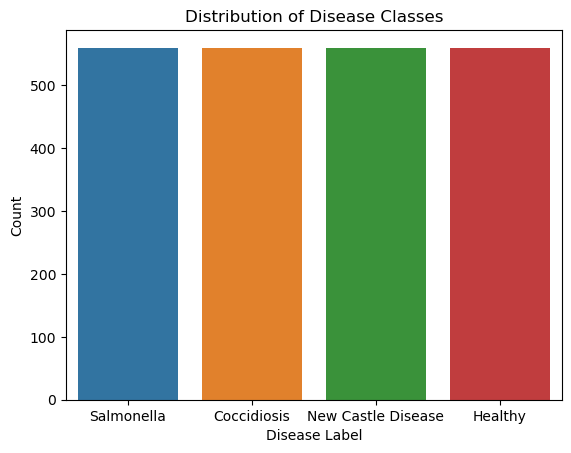

In [116]:
sns.countplot(data=balanced_df, x="label")
plt.xlabel("Disease Label")
plt.ylabel("Count")
plt.title("Distribution of Disease Classes")
plt.show()

# It's clear tha data is unbalanced so I will try to do some fix this later. 

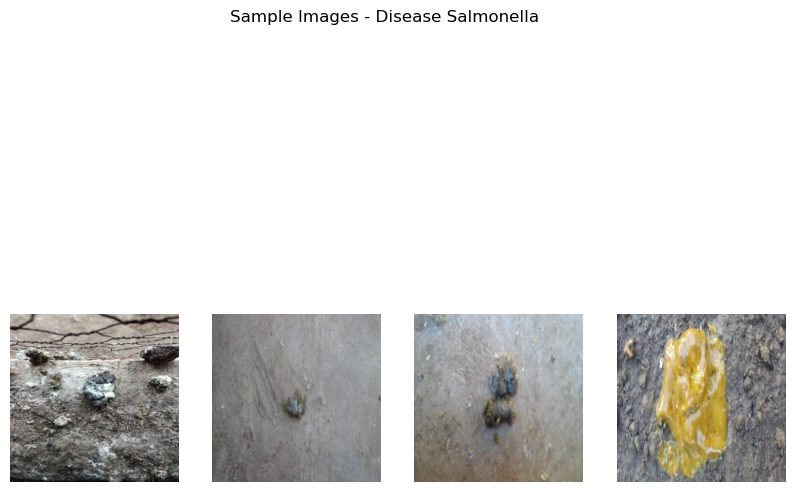

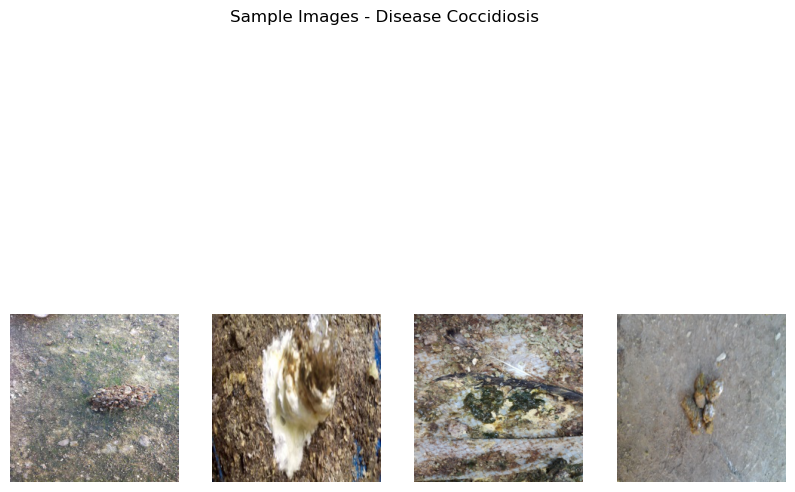

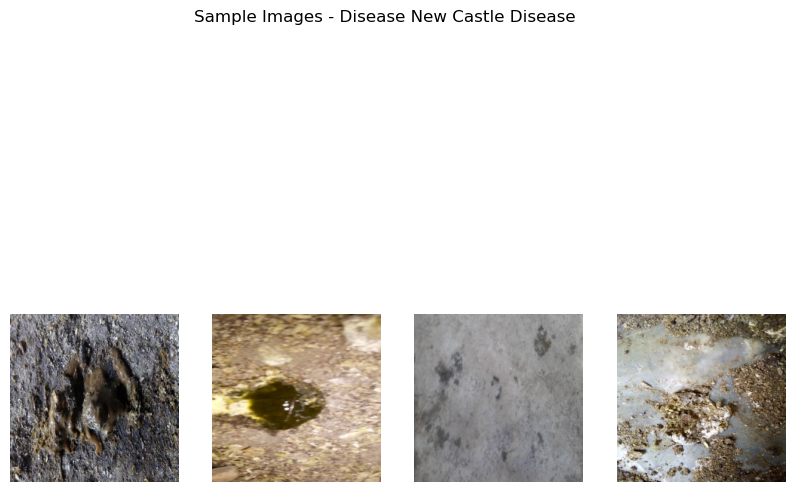

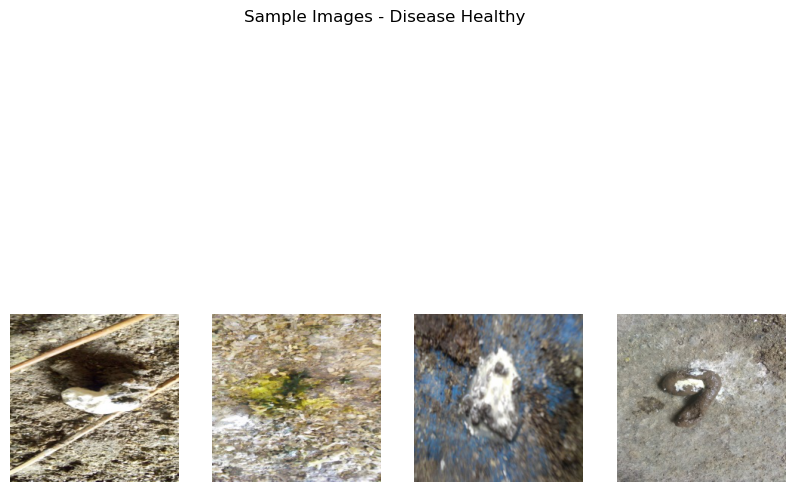

In [117]:
num_samples = 4
train_dir = "/home/kareem/Desktop/deep_learning/Mobile_architectures/chicken_diseases/chicken_disease/Train"
for disease_label in balanced_df["label"].unique():
    class_images = balanced_df.loc[labels_df["label"] == disease_label, "images"].sample(
        num_samples
    )
    plt.figure(figsize=(10, 8))

    for i, image_file_name in enumerate(class_images):
        image_path = os.path.join(train_dir, image_file_name)
        image = Image.open(image_path)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.suptitle(f"Sample Images - Disease {disease_label}")
    plt.show()

In [118]:
balanced_df["images"] = balanced_df["images"].apply(
    lambda x: os.path.join(train_dir, x)
)
balanced_df["images"].head()

0    /home/kareem/Desktop/deep_learning/Mobile_arch...
1    /home/kareem/Desktop/deep_learning/Mobile_arch...
2    /home/kareem/Desktop/deep_learning/Mobile_arch...
3    /home/kareem/Desktop/deep_learning/Mobile_arch...
4    /home/kareem/Desktop/deep_learning/Mobile_arch...
Name: images, dtype: object

In [148]:
balanced_df.head()

,images,label
0,/home/kareem/Desktop/deep_learning/Mobile_arch...,Salmonella
1,/home/kareem/Desktop/deep_learning/Mobile_arch...,Salmonella
2,/home/kareem/Desktop/deep_learning/Mobile_arch...,Salmonella
3,/home/kareem/Desktop/deep_learning/Mobile_arch...,Salmonella
4,/home/kareem/Desktop/deep_learning/Mobile_arch...,Salmonella


In [120]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.model_selection import train_test_split


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

img_size = (224, 224)
batch_size = 10

trgen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

t_and_v_gen = ImageDataGenerator()

train_gen = trgen.flow_from_dataframe(
    train_df,
    x_col='images',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = t_and_v_gen.flow_from_dataframe(
    val_df,
    x_col='images',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)

test_gen = t_and_v_gen.flow_from_dataframe(
    test_df,
    x_col='images',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

# Obtain information from the generator for later use
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels

print('Test batch size:', test_batch_size)
print('Test steps:', test_steps)
print('Number of classes:', class_count)
print('{0:^25s}{1:^12s}'.format('Class name', 'Class index'))

for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')


Found 1433 validated image filenames belonging to 4 classes.
Found 359 validated image filenames belonging to 4 classes.
Found 448 validated image filenames belonging to 4 classes.
Test batch size: 64
Test steps: 7
Number of classes: 4
       Class name        Class index 
       Coccidiosis            0      
         Healthy              1      
   New Castle Disease         2      
       Salmonella             3      


In [143]:
num_classes = 4
# model = tf.keras.Sequential(
#     [
#         base_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(num_classes, activation="softmax"),
#     ]
# )
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

img_shape = (img_size[0], img_size[1], 3)
base_model = MobileNetV3Small(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3),pooling="max"
)
base_model.trainable = True

x = base_model.output
print("base model shape: ",x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.3, seed=123)(x)
x = Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

lr = 0.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    callbacks=[early_stop, model_checkpoint, tensorboard],
)

test_loss, test_acc = model.evaluate(test_gen)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

base model shape:  KerasTensor(type_spec=TensorSpec(shape=(None, 576), dtype=tf.float32, name=None), name='max_pool/Max:0', description="created by layer 'max_pool'")
Epoch 1/5


2023-07-12 13:50:52.403390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


144/144 [==============================] - ETA: 0s - loss: 15.5008 - accuracy: 0.7306

2023-07-12 13:51:33.113938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


144/144 [==============================] - 44s 249ms/step - loss: 15.5008 - accuracy: 0.7306 - val_loss: 13.1355 - val_accuracy: 0.8914
Epoch 2/5
144/144 [==============================] - 36s 250ms/step - loss: 10.8291 - accuracy: 0.8590 - val_loss: 9.2928 - val_accuracy: 0.8357
Epoch 3/5
144/144 [==============================] - 35s 244ms/step - loss: 7.8096 - accuracy: 0.8646 - val_loss: 6.7823 - val_accuracy: 0.8691
Epoch 4/5
144/144 [==============================] - 35s 244ms/step - loss: 5.7474 - accuracy: 0.8904 - val_loss: 5.0024 - val_accuracy: 0.9081
Epoch 5/5
144/144 [==============================] - 36s 249ms/step - loss: 4.3709 - accuracy: 0.9065 - val_loss: 3.8868 - val_accuracy: 0.8830


2023-07-12 13:53:58.732132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 3s 466ms/step - loss: 3.9913 - accuracy: 0.8571
Test loss: 3.991339921951294
Test accuracy: 0.8571428656578064


In [150]:
from PIL import Image
import numpy as np

class_labels = np.unique(balanced_df["label"])
print("Class Labels:", class_labels, '\n')

out_of_scope = "paint.jpg"

for class_label in class_labels:
    class_subset = balanced_df[balanced_df["label"] == class_label]
    image_path = class_subset.iloc[0]['images']
    print(image_path)
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Adjust size as required
#     image = np.array(image) / 255.0 #This is the cause of the error # Normalize pixel values 
    image = np.expand_dims(image, axis=0)  # Add batch dimension if required

    predictions = model.predict(image)
    formatted_predictions = ["{:.4f}".format(prob) for prob in predictions[0]]
    print("Predictions:", formatted_predictions)
#   print("Probability Sum:", np.sum(predictions, axis=1))

    predicted_class = np.argmax(predictions, axis=1)
    print("Predicted Class:", predicted_class)
    print("Class Label:", class_label)
    print("Image Path:", image_path.split("/")[-1])


Class Labels: ['Coccidiosis' 'Healthy' 'New Castle Disease' 'Salmonella'] 

/home/kareem/Desktop/deep_learning/Mobile_architectures/chicken_diseases/chicken_disease/Train/cocci.1984.jpg
1/1 [==============================] - 1s 637ms/step
Predictions: ['0.8575', '0.0416', '0.0528', '0.0481']
Predicted Class: [0]
Class Label: Coccidiosis
Image Path: cocci.1984.jpg
/home/kareem/Desktop/deep_learning/Mobile_architectures/chicken_diseases/chicken_disease/Train/healthy.2035.jpg
1/1 [==============================] - 0s 24ms/step
Predictions: ['0.0028', '0.9730', '0.0159', '0.0083']
Predicted Class: [1]
Class Label: Healthy
Image Path: healthy.2035.jpg
/home/kareem/Desktop/deep_learning/Mobile_architectures/chicken_diseases/chicken_disease/Train/pcrncd.53.jpg
1/1 [==============================] - 0s 25ms/step
Predictions: ['0.0232', '0.0457', '0.9032', '0.0279']
Predicted Class: [2]
Class Label: New Castle Disease
Image Path: pcrncd.53.jpg
/home/kareem/Desktop/deep_learning/Mobile_architect

2023-07-12 14:02:36.294485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 4s 457ms/step


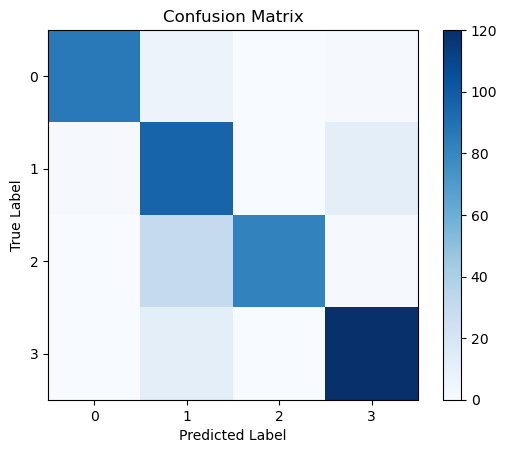

Classification Report:
----------------------
                     precision    recall  f1-score   support

        Salmonella     0.9885    0.9149    0.9503        94
       Coccidiosis     0.6621    0.8807    0.7559       109
New Castle Disease     1.0000    0.7257    0.8410       113
           Healthy     0.8955    0.9091    0.9023       132

          accuracy                         0.8571       448
         macro avg     0.8865    0.8576    0.8624       448
      weighted avg     0.8846    0.8571    0.8613       448



In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
classes = list(labels_df["label"].unique())

# Predict labels for the test data
predictions = model.predict(test_gen)
y_true = test_gen.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)


## How to convert my model into tensorflow Light 

In [152]:
import tensorflow as tf

# Save the model in the SavedModel format
model.save('kheva4')

# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('kheva4')
tflite_model = converter.convert()

# Save the converted TensorFlow Lite model to a file
with open('kheva4.tflite', 'wb') as f:
    f.write(tflite_model)


2023-07-12 14:03:02.237302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-12 14:03:02.256212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-07-12 14:03:06.720289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-12 14:

INFO:tensorflow:Assets written to: kheva4/assets


INFO:tensorflow:Assets written to: kheva4/assets
2023-07-12 14:03:16.651486: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-12 14:03:16.651512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-12 14:03:16.651716: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: kheva4
2023-07-12 14:03:16.674132: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-12 14:03:16.674165: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: kheva4
2023-07-12 14:03:16.745294: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-12 14:03:17.370218: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: kheva4
2023-07-12 14:03:17.537785: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: succes

## Test the Model 

In [76]:
import tensorflow as tf

# Specify the path to the saved model file
model_path = 'best_model.h5'

# Load the model
model = tf.keras.models.load_model(model_path)
